# Cascading Food Risks

## Imports

In [1]:
import pandas as pd
import networkx as nx
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from IPython.display import Image
from fuzzywuzzy import fuzz, process
import math

%matplotlib inline

## Functions

In [27]:
with open('hard_country_lookup.pickle', 'rb') as handle:
    manual_lookup = pickle.load(handle)

def create_nx_edge_from_trade_row(row):
    if row.element == 'Import Quantity':
        return (row.partner, row.reporter)
    elif row.element == 'Export Quantity':
        return (row.reporter, row.partner)
    else:
        print(f'Unknown edge type: {row.element}')

def create_trade_graph(trade_data):

    G = nx.DiGraph()

    for i, row in trade_data.iterrows():
        
        proposed_edge = create_nx_edge_from_trade_row(row)

        if G.has_edge(*proposed_edge):
            G.add_edge(*proposed_edge, amount= (G.get_edge_data(*proposed_edge)['amount'] + row.value)/2)
        else:
            G.add_edge(*proposed_edge, amount=row.value)
    
    return G


def best_fuzzy_match(text, candidates):
    best = process.extractOne(text, candidates)
    return best[0]
    

def get_lon_lat_from_country_name(name, lookup):
    return lookup.get(name) or manual_lookup[name]

## Graph Generation

In [3]:
trade_data = pd.read_csv("https://raw.githubusercontent.com/zutn/Trade-Reduction/master/trade_by_country_2017.csv", sep=";")

In [4]:
print(len(trade_data))

36365


In [5]:
trade_data.sample(4)

Reporter Countries  Partner Countries          Element    Y2017
567               Angola  Republic of Korea  Import Quantity    493.0
32693               Togo           Eswatini  Export Quantity      4.0
18701            Lebanon       Saudi Arabia  Import Quantity  54796.0
30902          Sri Lanka            Hungary  Export Quantity   1226.0

In [6]:
trade_data.columns = ['reporter', 'partner', 'element', 'value']
trade_data.sample(4)

reporter           partner          element    value
32533     Thailand           Nigeria  Export Quantity  60621.0
9440       Denmark     Faroe Islands  Import Quantity    183.0
6022         Chile      Burkina Faso  Export Quantity     57.0
31809  Switzerland  French Polynesia  Import Quantity      4.0

In [7]:
trade_graph = create_trade_graph(trade_data)

## Graph Visualisation

In [28]:
# To plot trade on a map, we first need the geographical coordinates of each country

# 1. Grab centroid data from online
country_centroids = pd.read_csv("http://worldmap.harvard.edu/download/wfs/34645/csv?outputFormat=csv&service=WFS&request=GetFeature&format_options=charset%3AUTF-8&typename=geonode%3Acountry_centroids_az8&version=1.0.0")

# 2. Create a lookup table from country name to centroid
name_to_centroid = {row['name']: (row['Longitude'], row['Latitude']) for _, row in country_centroids.to_dict('index').items()}

# 3. For each unique country in our trade data, find it's corresponding centroid using the lookup table, plus a manual one I made for the trickier country names (saved as a pickle)
pos = {country: get_lon_lat_from_country_name(country, name_to_centroid) for country in trade_data.partner.unique()}

In [9]:
# We'll make node size dependent on degree - i.e. number of trade connections
deg = nx.degree(trade_graph)
sizes = [2 * deg[country] for country in trade_graph.nodes]

In [19]:
# We'll make node size dependent on amount - i.e. volume of trade
amounts = [trade_graph[u][v]['amount'] for u,v in trade_graph.edges()]
max_amount = max(amounts)
weights = [max((50 * float(i)/max_amount), 0.005) for i in amounts]

In [20]:
# Display labels if at least 100 connections
labels = {country: country if deg[country] >= 200 else '' for country in trade_graph.nodes}

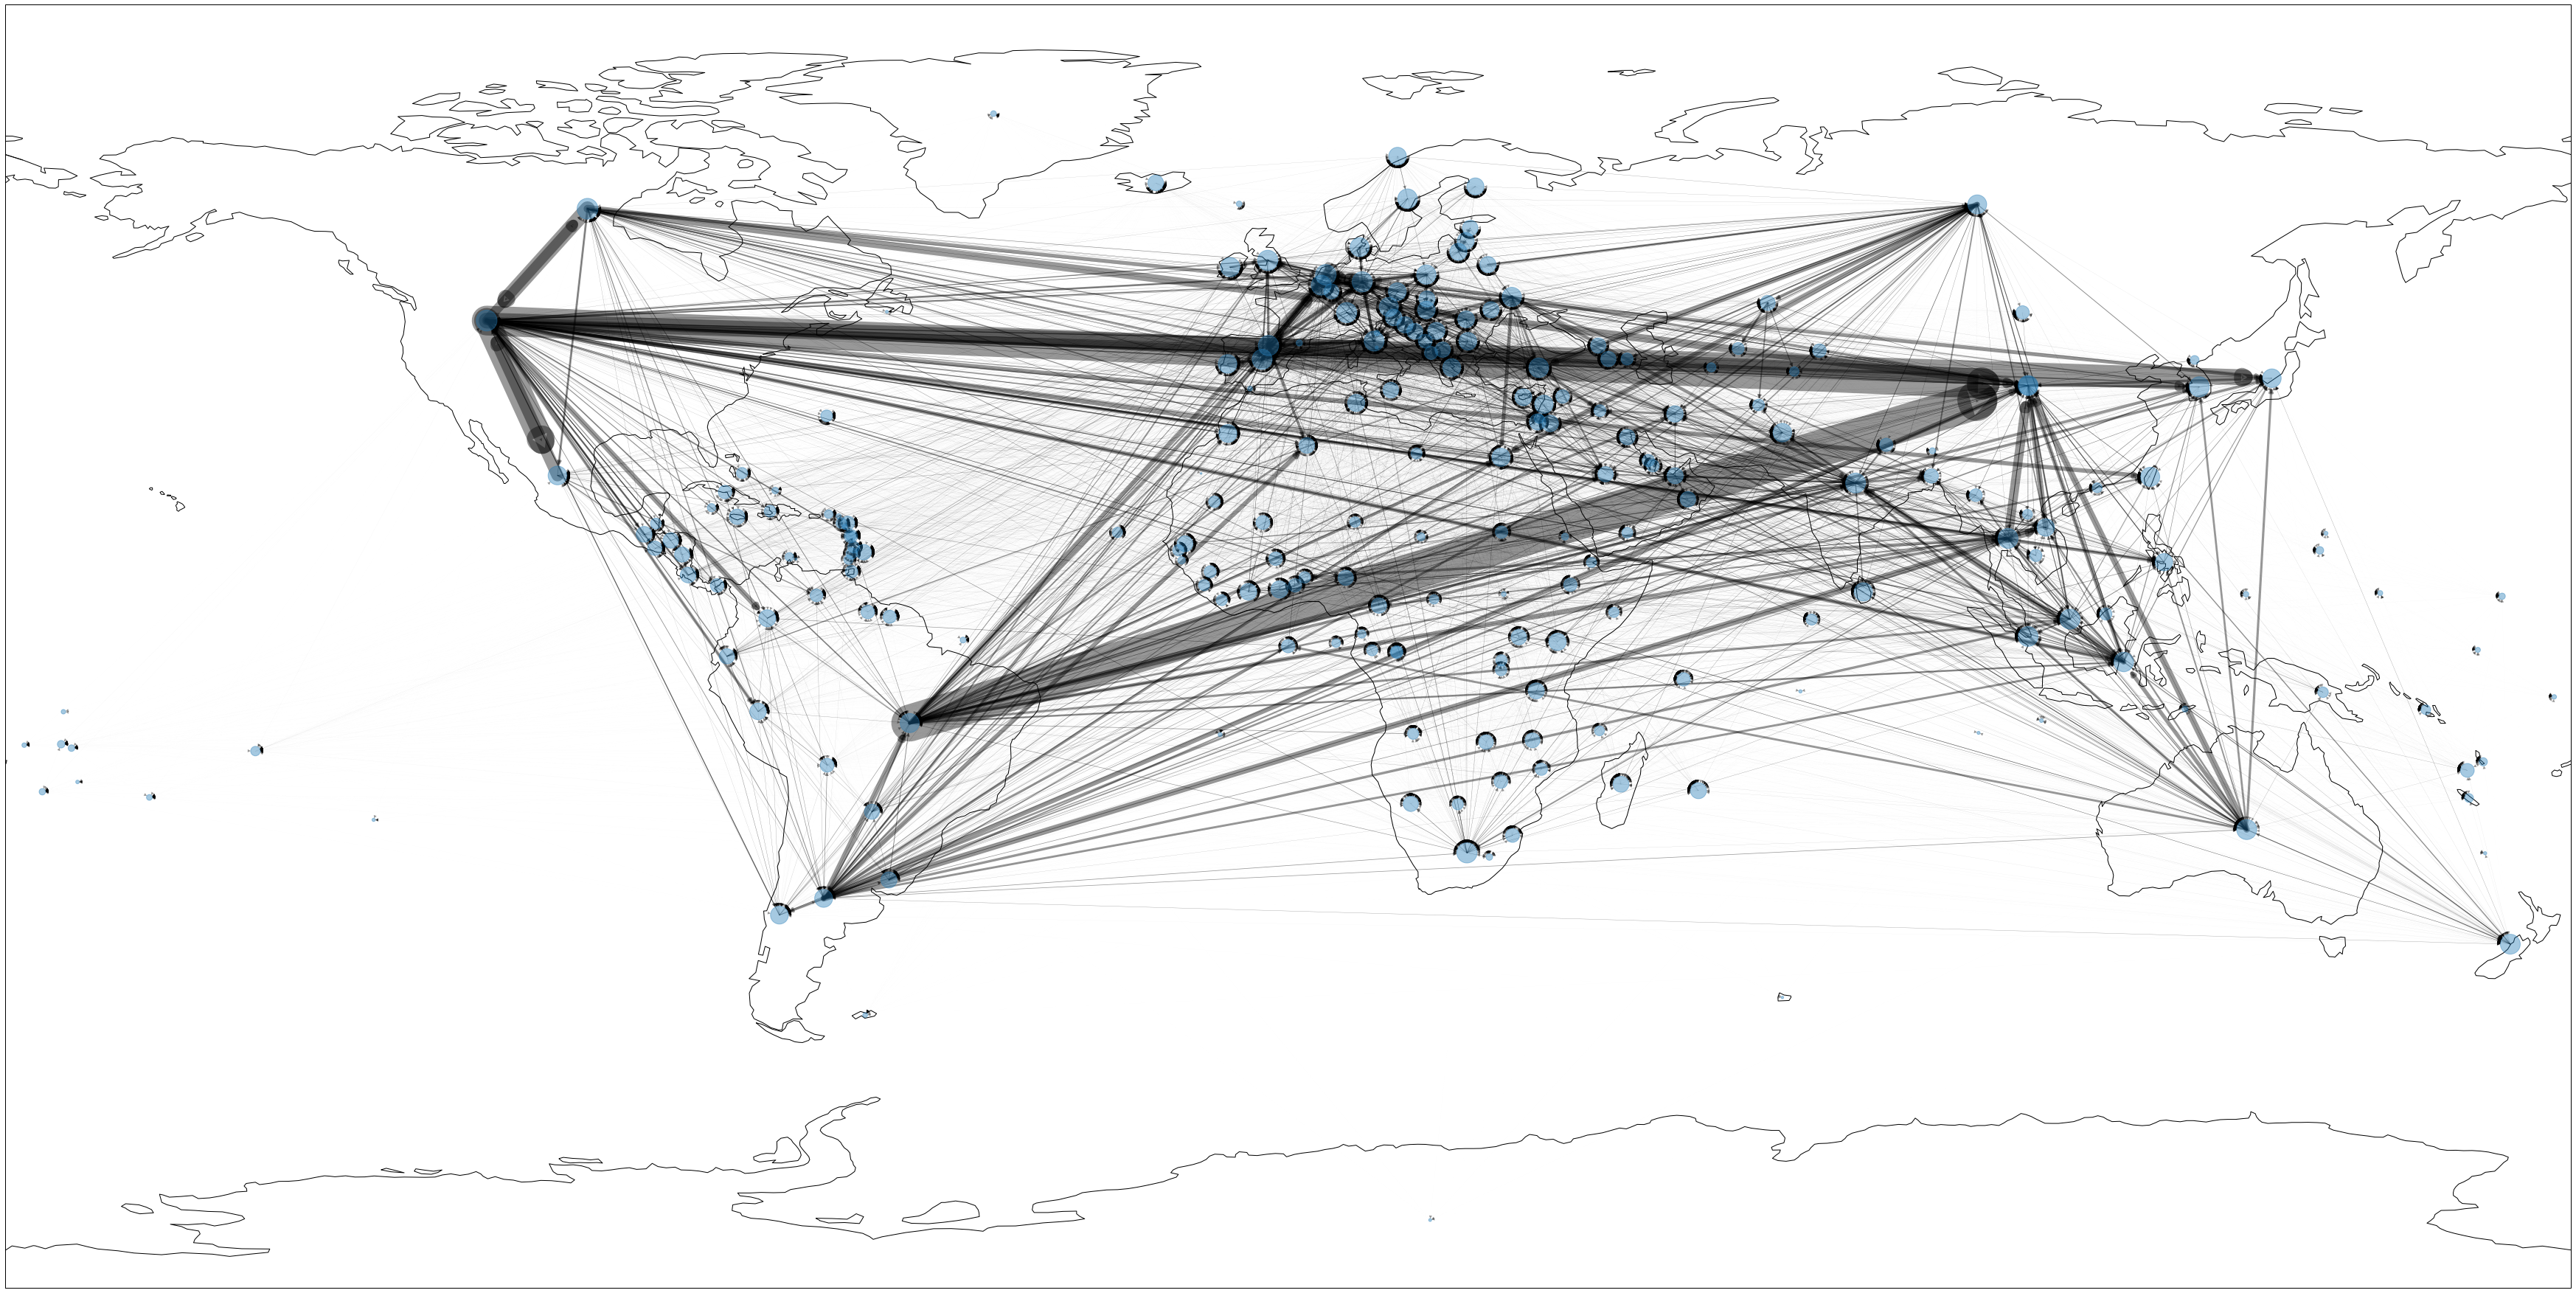

In [30]:
# Project graph onto a map
crs = ccrs.PlateCarree()
fig, ax = plt.subplots(
    1, 1, figsize=(72, 32),
    subplot_kw=dict(projection=crs))
ax.coastlines()
nx.draw_networkx(
    trade_graph, 
    ax=ax,
    font_size=16,
    alpha=.4,
    width=weights,
    node_size=sizes,
    with_labels=False,
    pos=pos,
#     edge_color=weights,
    edge_cmap=plt.cm.winter,
)